# Simple Linear Regression

Simple linear regression is a concept that makes a lot of sense intuitively but can be hard to explain concretely (like 'minimising the sum of squares'). It's not until I came across ["Introduction to Statistical Learning"](https://www.amazon.com/Introduction-Statistical-Learning-Applications-Statistics/dp/1461471370/) that I realised how wooly my understanding was.

## The dataset

For this exercise we'll be looking the relationship between head size and brain weight, leveraging the results from a [1905 study](http://www.stat.ufl.edu/~winner/data/brainhead.txt) (no less). The data is in a fixed width format, perfect for pandas' `read_fwf`.

In [2]:
import requests, pandas, io
url='http://www.stat.ufl.edu/~winner/data/brainhead.dat'
data=requests.get(url)
col_names=('gender', 'age_range', 'head_size', 'brain_weight')
col_widths=[(8,8),(16,16),(21-24),(29-32)]
df=pandas.read_fwf(io.StringIO(data.text), names=col_names, colspec=col_widths)
df.head()

,gender,age_range,head_size,brain_weight
0,1,1,4512,1530
1,1,1,3738,1297
2,1,1,4261,1335
3,1,1,3777,1282
4,1,1,4177,1590


Now that we have our data in a DataFrame, let's plot `brain_weight` against `head_size`.

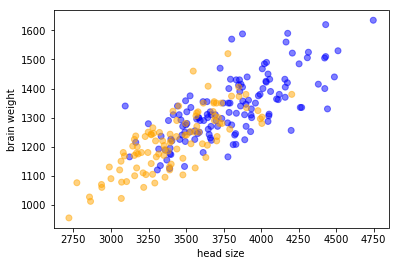

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
# here males will be plotted as blue and femals as orange
df['colour'] = df.apply(lambda r: 'blue' if r['gender'] == 1 else 'orange', axis=1)
plt.scatter(df.head_size, df.brain_weight, c=df.colour, alpha=0.5)
plt.xlabel('head size')
plt.ylabel('brain weight')
#TODO add legend to plot!

## Regression

At first glance it does look like there is some sort of linear relationship between those two variables. What we'll try and do is to plot the line that best illustrates the relationship based on our sample data. If you remember (or don't), a line has the form `y = mx + b` where `m` is the slope and `b` the `y` intercept. In regression form that is $Y \approx \beta_0 + \beta_1 X$ with $\beta_0$ and $\beta_1$ being the intercept and slope respectively - which is to say we are looking to model `brain_weight` onto `head_size`.

### Coefficients

In order for our line to be a good fit, we need to define what a good fit is. For us that means finding a line that is as close to all the points as possible. Given they don't all fit on a single line it means some points will be a better fit than others.

Let's plot a naive regression line that fits the smallest and maximum head size sample points.

2720 955 4747 1635


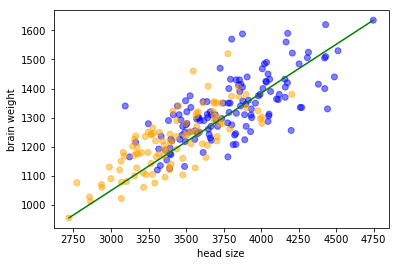

In [4]:
o=df.ix[df['head_size'].idxmin()]
x1,y1=o.head_size,o.brain_weight
o=df.ix[df['head_size'].idxmax()]
x2,y2=o.head_size,o.brain_weight
print(x1,y1,x2,y2)
plt.scatter(df.head_size, df.brain_weight, c=df.colour, alpha=0.5)
# add the naive regression line
plt.plot([x1,x2],[y1,y2], c='green')
plt.xlabel('head size')
plt.ylabel('brain weight')

In [5]:
# calculate the slope
m=(y2-y1)/(x2-x1)
# solve for the intercept
b=y1-m*x1
beta_0, beta_1 = b, m
beta_0, beta_1

(42.518500246669987, 0.33547113961519487)

Substituting in the above this means $\beta_0 = -637.48$ and $\beta_1 = 0.335$. But how good a fit is this? We define the error to be the squared difference of our estimate vs the actual (sampled) points. Note that we take the squared difference as otherwise positive and negative differences might cancel each other out. For instance for $e_2 = y_2 - \hat{y_2}$, where $\hat{y_2} = \hat{\beta_0} + \hat{\beta_1}x$, is calculated as follows:

In [6]:
# to verify our coefficiencts are correct, replace iloc[1] by iloc[0] or iloc[-1]
x_2, y_2 = df.sort_values(['head_size']).iloc[1][['head_size', 'brain_weight']]
print(x_2, y_2)
estimated_y_2 = beta_0 + beta_1*x_2
error_2 = y_2 - estimated_y_2
error_2

2773 1076


103.2200296003947

Let's calculate the residual sum of squares (RSS) which is nothing more than the sum of each error squared $\sum_{i=1}^n{e_i^2}$:

In [7]:
df['error'] = df.apply(lambda r: r['brain_weight'] - beta_0 - beta_1*r['head_size'], axis=1)
rss = sum(df['error']**2)
rss

1503218.8128294651

As it turns out there's an analytical solution for the least square coefficient estimates of $\beta_0$ and $\beta_1$. $RSS = (y_1 - \hat{\beta_0} - \hat{\beta_1}x_1)^2 + ... + (y_n - \hat{\beta_0} - \hat{\beta_1}x_n)^2 = \sum_{i=1}^n(y_i - \hat{\beta_0} - \hat{\beta_1}x_i)^2$. 

Expanding the squared term, we get $\sum_{i=1}^n(y_i^2 - 2y_i\hat{\beta_0} - 2y_i\hat{\beta_1}x_i + 2\hat{\beta_0}\hat{\beta_1}x_i + \hat{\beta_0}^2 + \hat{\beta_1}^2x_i^2)$. We can now take the first partial derivative of RSS once with respect to $\beta_0$ and once with respect to $\beta_1$ to get two equations:

$\frac{\partial RSS}{\partial \hat{\beta_0}} = \sum(-2y_i + 2\hat{\beta_1}x_i + 2\hat{\beta_0})$

$\frac{\partial RSS}{\partial \hat{\beta_1}} = \sum(-2y_ix_i + 2\hat{\beta_0}x_i + 2\hat{\beta_1}x_i^2)$

Setting both to zero would yield the local minimum - giving us 2 equations with 2 unknowns. We can solve those normal equations by subsituation to yield:

$\hat{\beta_1} = \frac{\sum(x_i - \hat{x})(y_i - \hat{y})}{\sum(x_i - \hat{x})^2} $

$\hat{\beta_0} = \bar{y} - \hat{\beta_1}\bar{x}$

Which we can compute:

In [8]:
brain_weight_sample_mean = df['brain_weight'].mean()
head_size_sample_mean = df['head_size'].mean()

b_1 = sum(df.apply(lambda r: (r['head_size']-head_size_sample_mean)*(r['brain_weight']-brain_weight_sample_mean), axis=1))
b_1 /= sum(df.apply(lambda r: (r['head_size']-head_size_sample_mean)**2, axis=1))

b_0 = brain_weight_sample_mean-b_1*head_size_sample_mean
print(b_0, b_1)

df['error'] = df.apply(lambda r: r['brain_weight'] - b_0 - b_1*r['head_size'], axis=1)
rss = sum(df['error']**2)
rss

325.573421049 0.263429339489


1232728.014636552

Yielding a smaller residual sum of squares, and hence a better approximation. Graphing all of this:

2720 955 4747 1635


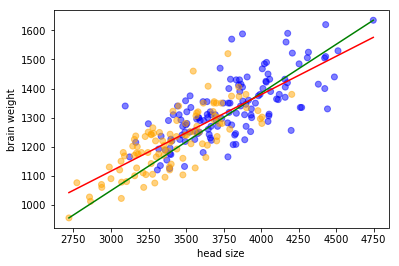

In [9]:
o=df.ix[df['head_size'].idxmin()]
x1,y1=o.head_size,o.brain_weight
o=df.ix[df['head_size'].idxmax()]
x2,y2=o.head_size,o.brain_weight
print(x1,y1,x2,y2)
plt.scatter(df.head_size, df.brain_weight, c=df.colour, alpha=0.5)
# add the naive regression line
plt.plot([x1,x2],[y1,y2], c='green')
# add the one with minimised sum of squares
plt.plot([x1,x2],[b_0+b_1*x1,b_0+b_1*x2], c='red')
plt.xlabel('head size')
plt.ylabel('brain weight')

### Confidence intervals for the parameters

The regression line is an appromixation. Assuming the underlying relationship is linear (which it may not be - it clearly doesn't seem that way with our dataset), what we really want is to see how close our $\hat{\beta}$ estimates are to the actual $\beta$ parameters.

To do this we'll need to compute the standard error of the sampling distribution of $\beta$s. Imagine we had another sample of length $n$ - we'd then find another $\hat{\beta}$. If we were to repeat that multiple times over, the Central Limit Theorem tells us that $\hat{\beta_1} \sim N(\beta_1, \mathrm{Var}(\beta_1))$ - which would enable us to give a confidence interval for $\beta_1$.

The derivation is available [here](http://stats.stackexchange.com/a/89155) and simplifies to $\frac{\sigma^2}{\sum(x_i-\bar{x})^2}$, but we still need to estimate $\sigma^2$. Recall we assume the 'true' relationship is written as $Y = \beta_0 + \beta_1X + \epsilon$ where $\epsilon$ denotes the error which is drawn from $N(0,\sigma^2)$ (a normal distribution with zero mean), and independent for each observation - $\sigma^2$ is nothing more than $\mathrm{Var}(\epsilon)$, which is also the mean squared error (MSE). That is just $\frac{1}{n-2}\mathrm{RSS}$. We know that 95% of the observation on a normal distribution should be within 2 standard deviations of the mean. Our confidence interval for $\hat{\beta_1}$ is therefore:

In [20]:
import math
mse = rss/(len(df)-2)
x_bar = df.head_size.mean()
var_b1 = mse/sum(df.apply(lambda r: (r['head_size']-x_bar)**2, axis=1))
stdev_b1 = math.sqrt(var_b1)
print(stdev_b1)
lower_bound, upper_bound = b_1-2*stdev_b1, b_1+2*stdev_b1
lower_bound, upper_bound

0.012907433440886976


(0.2376144726076255, 0.28924420637117343)

Done!

And just for kicks, this is how you do all of the above in 2 lines by leveraging `scipy`:

In [18]:
from scipy.stats import linregress
linregress(df.head_size,df.brain_weight)

LinregressResult(slope=0.26342933948939939, intercept=325.57342104944235, rvalue=0.79956970925429616, pvalue=5.9576308394065412e-54, stderr=0.012907433440886988)

Though now it's a lot clearer for me as to how those values are derived and `linregress` is no longer a black box!

Some resources:

* http://seismo.berkeley.edu/~kirchner/eps_120/Toolkits/Toolkit_10.pdf
* http://stattrek.com/regression/slope-confidence-interval.aspx?Tutorial=AP
* http://www.stat.ufl.edu/~winner/qmb3250/notespart2.pdf
* http://data.princeton.edu/wws509/notes/c2s4.html
* http://stats.stackexchange.com/questions/44838/how-are-the-standard-errors-of-coefficients-calculated-in-a-regression/44841#44841
* http://stats.stackexchange.com/questions/88461/derive-variance-of-regression-coefficient-in-simple-linear-regression/89155#89155
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3148365/